In [1]:
import logging
import glob
import pandas as pd
from stop_words import get_stop_words # stop words!


import gensim
from gensim import corpora
from gensim.corpora import Dictionary
from gensim.models.callbacks import PerplexityMetric
from gensim.models.wrappers import LdaMallet

In [3]:
logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO  

In [21]:
CORPUS_PATH = 'groene_amsterdammer_corpus/*.txt.out'

MIN_DF = 5 # minimum document frequency
MAX_DF = 0.6 #maximum document frequency

N_TOPICS = 10
ITERATIONS = 2000
EVAL_EVERY = 3 # for regular LDA 
N_WORKERS = 3 # number of CPU'S for multiprocessing

In [22]:
stop_words = get_stop_words('nl')

In [23]:
read_text = lambda x: [line.split('\t')[2].lower() for line 
                       in open(x, 'r', encoding='utf-8').read().splitlines() if len(line) > 2]
remove_stopwords = lambda x: [token for token in x if token not in stop_words and len(token) > 1]

texts = glob.glob(CORPUS_PATH, recursive=False)
tokenized_texts = [read_text(text) for text in texts]
tokenized_texts = [remove_stopwords(tokens) for tokens in tokenized_texts]

In [24]:
dictionary = Dictionary(tokenized_texts)
dictionary.filter_extremes(no_below=MIN_DF, no_above=MAX_DF)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

INFO : adding document #0 to Dictionary(0 unique tokens: [])
INFO : built Dictionary(98924 unique tokens: ['(slaven)handelaar', '(slaven)koper', '26', 'afrika', 'afrikaans']...) from 2326 documents (total 1426497 corpus positions)
INFO : discarding 79491 tokens: [('(slaven)handelaar', 1), ('(slaven)koper', 1), ('ander', 1505), ('elmina', 3), ('goed', 1423), ('komen', 1655), ('maken', 1579), ('plantage-economie', 4), ('rossum', 4), ('slavernijgeschiedenis', 3)]...
INFO : keeping 19433 tokens which were in no less than 5 and no more than 1395 (=60.0%) documents
INFO : resulting dictionary: Dictionary(19433 unique tokens: ['26', 'afrika', 'afrikaans', 'afrikanen', 'allemaal']...)


In [26]:
lda = LdaMallet('/Users/jorisveerbeek/mallet-2.0.8/bin/mallet', 
                corpus=corpus,
                id2word=dictionary,
                num_topics=N_TOPICS, 
                iterations=ITERATIONS,  
                workers=N_WORKERS)

INFO : serializing temporary corpus to /var/folders/hm/b7z9pj2s5954k95hn2hl_8fc0000gn/T/ddb040_corpus.txt
INFO : converting temporary corpus to MALLET format with /Users/jorisveerbeek/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /var/folders/hm/b7z9pj2s5954k95hn2hl_8fc0000gn/T/ddb040_corpus.txt --output /var/folders/hm/b7z9pj2s5954k95hn2hl_8fc0000gn/T/ddb040_corpus.mallet
INFO : training MALLET LDA with /Users/jorisveerbeek/mallet-2.0.8/bin/mallet train-topics --input /var/folders/hm/b7z9pj2s5954k95hn2hl_8fc0000gn/T/ddb040_corpus.mallet --num-topics 10  --alpha 50 --optimize-interval 0 --num-threads 3 --output-state /var/folders/hm/b7z9pj2s5954k95hn2hl_8fc0000gn/T/ddb040_state.mallet.gz --output-doc-topics /var/folders/hm/b7z9pj2s5954k95hn2hl_8fc0000gn/T/ddb040_doctopics.txt --output-topic-keys /var/folders/hm/b7z9pj2s5954k95hn2hl_8fc0000gn/T/ddb040_topickeys.txt --num-iterations 2000 --inferencer-filename /var/folde

In [149]:
rows = []
for topic in range(0, N_TOPICS):
    words = lda.show_topic(topic, 10)
    topic_n_words = ' '.join([word[0] for word in words])
    print('Topic {}: {}'.format(str(topic), topic_n_words))
    rows.append([str(topic), topic_n_words])
keys = pd.DataFrame(rows, columns=['topic', 'words'])

Topic 0: mens wereld nieuw alleen zoals mogelijk willen dier leven manier
Topic 1: werk kunst kunstenaar museum muziek beeld spelen zwart laat twee
Topic 2: zeggen willen weten kind denken zitten vinden vragen man heel
Topic 3: politiek partij eigen zoals samenleving tussen sociaal juist nederland cultuur
Topic 4: zeggen krijgen politie zaak rechter twee wet volgens media turkije
Topic 5: bedrijf nederland procent geld euro xfb01 zeggen overheid nederlands krijgen
Topic 6: schrijven boek leven verhaal vrouw xfb01 man roman lezen film
Topic 7: stad mens zeggen huis nieuw krijgen willen zitten wonen amsterdam
Topic 8: kijken weer licht liggen laten oog lijken twee hand achter
Topic 9: land europa europees politiek amerikaanse trump oorlog wereld nieuw duits


In [122]:
transformed_docs = lda.load_document_topics()
docs = [[texts[indx]] + [p[1] for p in doc] for indx, doc in enumerate(transformed_docs)]
composition = pd.DataFrame(docs, columns=['document_id'] + ['topic {}'.format(x) for x in range(0, N_TOPICS)])
composition.head()

,document_id,topic 0,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9
0,groene_amsterdammer_corpus/article_3034.txt.out,0.086614,0.086614,0.039370,0.181102,0.070866,0.125984,0.062992,0.070866,0.047244,0.228346
1,groene_amsterdammer_corpus/article_4072.txt.out,0.071791,0.027872,0.168919,0.319257,0.021959,0.063345,0.068412,0.063345,0.027872,0.167230
2,groene_amsterdammer_corpus/article_4893.txt.out,0.055794,0.090129,0.051502,0.047210,0.077253,0.120172,0.034335,0.137339,0.042918,0.343348
3,groene_amsterdammer_corpus/article_4062.txt.out,0.592994,0.032484,0.047134,0.079618,0.016561,0.033121,0.077707,0.015924,0.095541,0.008917
4,groene_amsterdammer_corpus/article_3024.txt.out,0.084615,0.361538,0.088462,0.076923,0.026923,0.038462,0.169231,0.038462,0.076923,0.038462


(-0.5, 499.5, 499.5, -0.5)

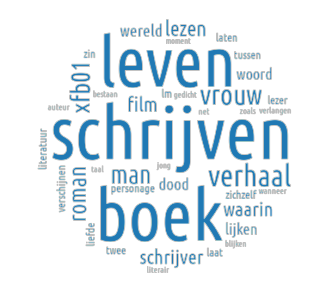

In [144]:
"""
Make wordcloud of topic based on its parameter value (association score)
"""


from wordcloud import WordCloud
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

TOPIC_N = 6
NUMBER_OF_WORDS = 50
circle_mask = np.array(Image.open("black_circle_better.png"))
words = dict(lda.show_topic(TOPIC_N, NUMBER_OF_WORDS))
wc = WordCloud(background_color="rgba(255, 255, 255, 0)", mode="RGBA",
                              font_path='/Users/jorisveerbeek/Downloads/UbuntuCondensed-Regular.ttf',
                              min_font_size=15,
                              margin=10,
                              mask=circle_mask,
                               color_func=lambda *args, **kwargs: (32,121,180),
                              colormap='tab10')
wc.generate_from_frequencies(words)
plt.figure(figsize=(5,5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")